# 1.Import Library

In [2]:
# Mengimport Library yang sering digunakan
import os, shutil
import zipfile
import random
from random import sample
import shutil
from shutil import copyfile
import pathlib
from pathlib import Path
import numpy as np
import pandas as pd
from tqdm.notebook import tqdm as tq

# library untuk visualisasi
import matplotlib.pyplot as plt
import seaborn as sns



# Mengimport Libraries untuk pemrosesan data gambar
import cv2
from PIL import Image
import skimage
from skimage import io
from skimage.transform import resize
from skimage.transform import rotate, AffineTransform, warp
from skimage import img_as_ubyte
from skimage.exposure import adjust_gamma
from skimage.util import random_noise

# Libraries untuk pembangunan model transfer learning dengan Xception
import keras
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator, img_to_array, load_img
from tensorflow.keras.applications import Xception
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dropout, Dense
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import Callback, EarlyStopping, ReduceLROnPlateau

import warnings
warnings.filterwarnings('ignore')

In [3]:
import tensorflow as tf
# Mencetak versi TensorFlow yang sedang digunakan
print(tf.__version__)

2.19.0


# 2.Data Loading

## Data Preparation

## Dataset Checking

In [4]:
combined_dir = "./fix-dataset"
print("acne folder exists:", os.path.exists(os.path.join(combined_dir, 'acne')))
print("hyperpigmentation folder exists:", os.path.exists(os.path.join(combined_dir, 'hyperpigmentation')))
print("Nail_psoriasis folder exists:", os.path.exists(os.path.join(combined_dir, 'Nail_psoriasis')))
print("SJS-TEN folder exists:", os.path.exists(os.path.join(combined_dir, 'SJS-TEN')))
print("Vitiligofolder exists:", os.path.exists(os.path.join(combined_dir, 'Vitiligo')))

acne folder exists: True
hyperpigmentation folder exists: True
Nail_psoriasis folder exists: True
SJS-TEN folder exists: True
Vitiligofolder exists: True


In [5]:
combined_dir = "./fix-dataset"
categories = ['acne', 'hyperpigmentation', 'Nail_psoriasis','SJS-TEN','Vitiligo']

for category in categories:
    category_dir = os.path.join(combined_dir, category)
    image_files = os.listdir(category_dir)
    print(f"Found {len(image_files)} images in {category} folder.")

Found 1043 images in acne folder.
Found 1028 images in hyperpigmentation folder.
Found 1100 images in Nail_psoriasis folder.
Found 1154 images in SJS-TEN folder.
Found 1100 images in Vitiligo folder.


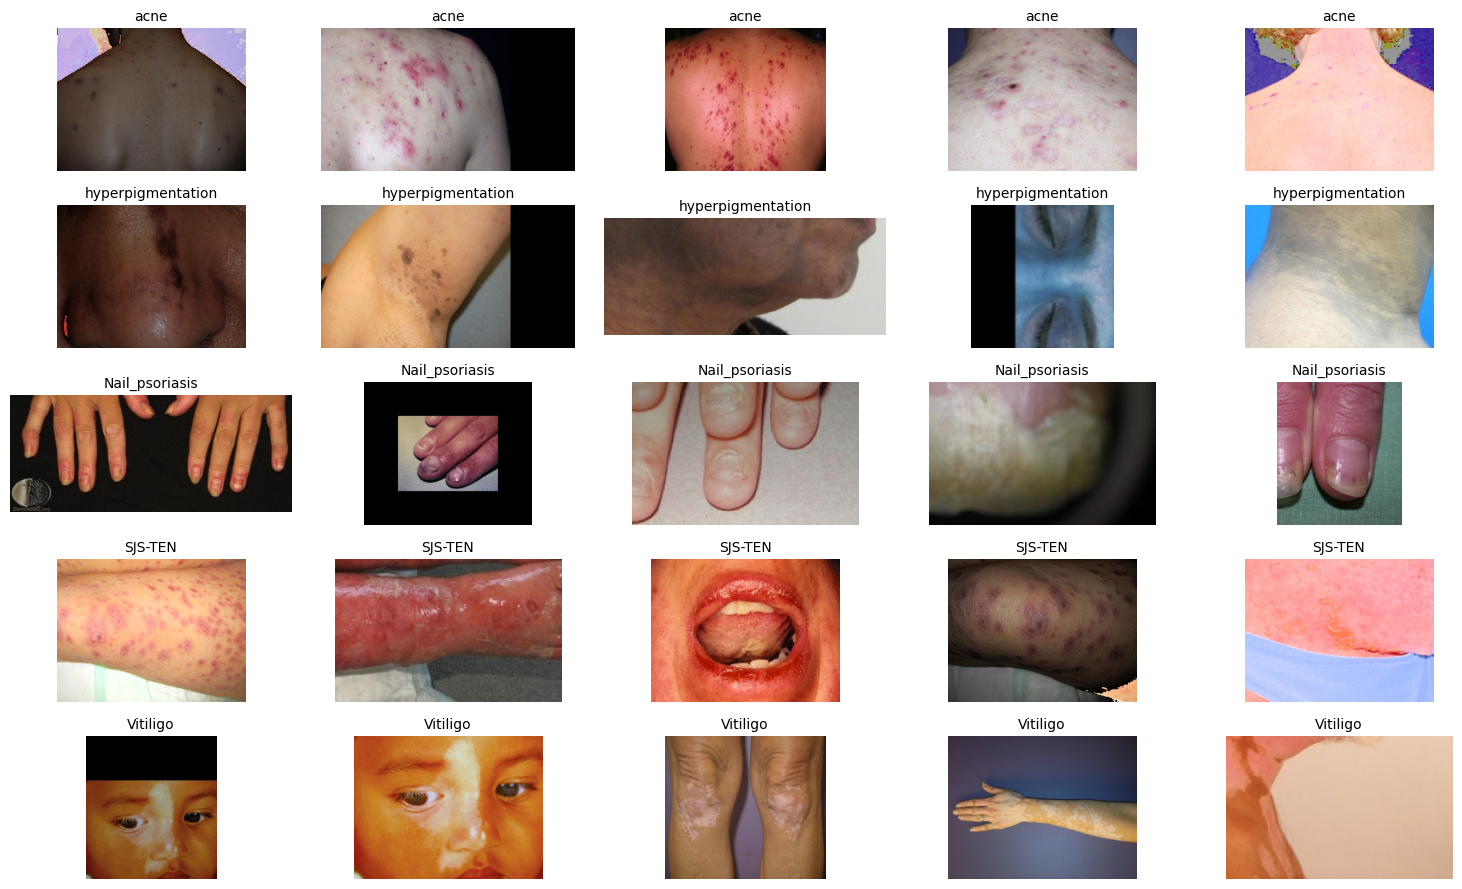

In [7]:
# Direktori dataset
combined_dir = "./fix-dataset"
categories = ['acne', 'hyperpigmentation', 'Nail_psoriasis','SJS-TEN','Vitiligo']

# membuat plot grid 3 baris (kelas) x 5 kolom (gambar per kelas)
fig, axes = plt.subplots(len(categories), 5, figsize=(15, 9))

for i, category in enumerate(categories):
    category_dir = os.path.join(combined_dir, category)
    image_files = os.listdir(category_dir)

    # mengambil 5 gambar acak dari setiap kelas
    sample_images = random.sample(image_files, 5)

    for j in range(5):
        image_path = os.path.join(category_dir, sample_images[j])
        img = Image.open(image_path)

        axes[i, j].imshow(img)
        axes[i, j].set_title(f"{category}", fontsize=10)
        axes[i, j].axis('off')

plt.tight_layout()
plt.show()

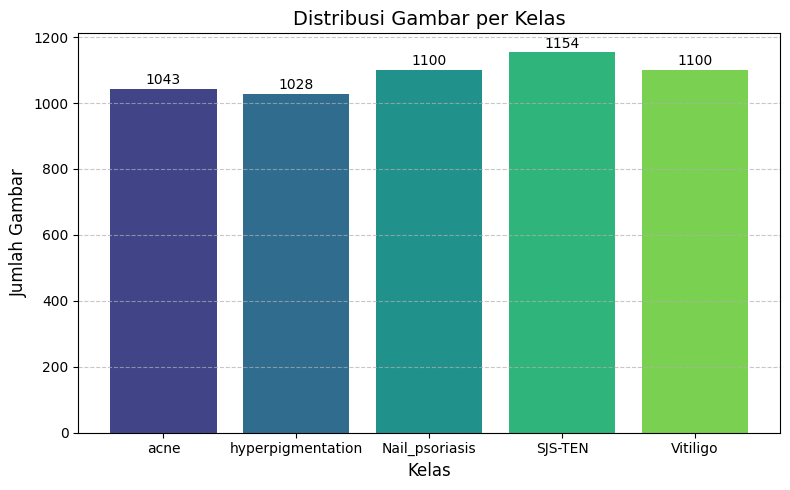

In [8]:
# Direktori dataset
combined_dir = "./fix-dataset"
categories = ['acne', 'hyperpigmentation', 'Nail_psoriasis','SJS-TEN','Vitiligo']

# menghitung jumlah gambar per kelas
image_counts = []
for category in categories:
    category_dir = os.path.join(combined_dir, category)
    image_files = os.listdir(category_dir)
    image_counts.append(len(image_files))

# Warna palet viridis
cmap = plt.get_cmap("viridis")
colors = cmap(np.linspace(0.2, 0.8, len(categories)))

# Plot bar chart
plt.figure(figsize=(8, 5))
bars = plt.bar(categories, image_counts, color=colors)
plt.title('Distribusi Gambar per Kelas', fontsize=14)
plt.xlabel('Kelas', fontsize=12)
plt.ylabel('Jumlah Gambar', fontsize=12)
plt.grid(axis='y', linestyle='--', alpha=0.7)

# menambahkan label angka di atas bar
for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, yval + 5, str(yval), ha='center', va='bottom', fontsize=10)

plt.tight_layout()
plt.show()

# 3.Data Splitting

In [10]:
# memmanggil variabel mypath yang menampung folder dataset gambar
mypath= './fix-dataset/'

file_name = []
labels = []
full_path = []
for path, subdirs, files in os.walk(mypath):
    for name in files:
        full_path.append(os.path.join(path, name))
        labels.append(path.split('/')[-1])
        file_name.append(name)


# Memasukan variabel yang sudah dikumpulkan pada looping di atas menjadi sebuah dataframe agar rapih
df = pd.DataFrame({"path":full_path,'file_name':file_name,"labels":labels})
# Melihat jumlah data gambar pada masing-masing label
df.groupby(['labels']).size()

labels
Nail_psoriasis       1100
SJS-TEN              1154
Vitiligo             1100
acne                 1043
hyperpigmentation    1028
dtype: int64

In [11]:
# Variabel yang digunakan pada pemisahan data ini dimana variabel x = data path dan y = data labels
X= df['path']
y= df['labels']

# Split dataset awal menjadi data train dan test
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=300)

In [12]:
# Menyatukan kedalam masing-masing dataframe
df_tr = pd.DataFrame({'path':X_train,'labels':y_train,'set':'train'})
df_te = pd.DataFrame({'path':X_test,'labels':y_test,'set':'test'})

In [13]:
# Print hasil diatas untuk melihat panjang size data training dan testing
print('train size', len(df_tr))
print('test size', len(df_te))

train size 4340
test size 1085


In [14]:
# menggabungkan DataFrame df_tr dan df_te
df_all = pd.concat([df_tr, df_te], ignore_index=True)

print('========================================= \n')
print(df_all.groupby(['set', 'labels']).size(), '\n')
print('========================================= \n')

# mengecek sample data
print(df_all.sample(5))


set    labels           
test   Nail_psoriasis       225
       SJS-TEN              239
       Vitiligo             201
       acne                 211
       hyperpigmentation    209
train  Nail_psoriasis       875
       SJS-TEN              915
       Vitiligo             899
       acne                 832
       hyperpigmentation    819
dtype: int64 


                                                   path    labels    set
5406  ./fix-dataset/SJS-TEN/flip-0sjs-ten-leg-101__P...   SJS-TEN   test
2962  ./fix-dataset/Vitiligo/hue-150vitiligo-20__Pro...  Vitiligo  train
3298  ./fix-dataset/Vitiligo/flip-1vitiligo-63__Prot...  Vitiligo  train
370         ./fix-dataset/acne/augmented_healthy_38.jpg      acne  train
943   ./fix-dataset/SJS-TEN/Crop-0350_0300sjs-ten-ar...   SJS-TEN  train


In [15]:
# Memanggil dataset asli yang berisi keseluruhan data gambar yang sesuai dengan labelnya
datasource_path = "./fix-dataset"
# Membuat variabel Dataset, dimana nanti menampung data yang telah dilakukan pembagian data training dan testing
dataset_path = "Final-Dataset/"

In [16]:
for index, row in tq(df_all.iterrows()):
    # mendeteksi filepath
    file_path = row['path']
    if not os.path.exists(file_path):
        file_path = os.path.join(datasource_path, row['labels'], row['image'])  # Menggunakan image langsung

    # membuat direktori tujuan jika belum ada
    dest_dir = os.path.join(dataset_path, row['set'], row['labels'])
    os.makedirs(dest_dir, exist_ok=True)

    # menentukan nama file tujuan
    destination_file_name = os.path.basename(file_path)  
    file_dest = os.path.join(dest_dir, destination_file_name)

    # menyalin file jika belum ada
    if not os.path.exists(file_dest):
        try:
            shutil.copy2(file_path, file_dest)
        except FileNotFoundError:
            print(f"[File tidak ditemukan] → {file_path}")

0it [00:00, ?it/s]

# 4.Image Data Generator dan Augmentasi Data

In [20]:
# mendefinisikan data training and test directori
TRAIN_DIR = "./Final-Dataset/train"
TEST_DIR = "./Final-Dataset/test"

train_acne = os.path.join(TRAIN_DIR, 'acne')
train_hyperpigmentation = os.path.join(TRAIN_DIR, 'hyperpigmentation')
train_Nail_psoriasis = os.path.join(TRAIN_DIR, 'Nail_psoriasis')
train_SJS_TEN = os.path.join(TRAIN_DIR, 'SJS-TEN')
train_Vitiligo = os.path.join(TRAIN_DIR, 'Vitiligo')

test_acne = os.path.join(TEST_DIR, 'acne')
test_hyperpigmentation = os.path.join(TEST_DIR, 'hyperpigmentation')
test_Nail_psoriasis = os.path.join(TEST_DIR, 'Nail_psoriasis')
test_SJS_TEN = os.path.join(TEST_DIR, 'SJS-TEN')
test_Vitiligo = os.path.join(TEST_DIR, 'Vitiligo')

print("Total number of acne images in training set: ", len(os.listdir(train_acne)))
print("Total number of hyperpigmentation images in training set: ", len(os.listdir(train_hyperpigmentation)))
print("Total number of Nail_psoriasis images in training set: ", len(os.listdir(train_Nail_psoriasis)))
print("Total number of SJS-TEN images in training set: ", len(os.listdir(train_SJS_TEN)))
print("Total number of Vitiligo images in training set: ", len(os.listdir(train_Vitiligo)))

print("Total number of acne images in test set: ", len(os.listdir(test_acne)))
print("Total number of hyperpigmentation images in test set: ", len(os.listdir(test_hyperpigmentation)))
print("Total number of Nail_psoriasis images in test set: ", len(os.listdir(test_Nail_psoriasis)))
print("Total number of SJS-TEN images in test set: ", len(os.listdir(test_SJS_TEN)))
print("Total number of Vitiligo images in test set: ", len(os.listdir(test_Vitiligo)))

Total number of acne images in training set:  832
Total number of hyperpigmentation images in training set:  819
Total number of Nail_psoriasis images in training set:  875
Total number of SJS-TEN images in training set:  915
Total number of Vitiligo images in training set:  899
Total number of acne images in test set:  211
Total number of hyperpigmentation images in test set:  209
Total number of Nail_psoriasis images in test set:  225
Total number of SJS-TEN images in test set:  239
Total number of Vitiligo images in test set:  201


In [21]:
# membuat ImageDataGenerator object normalizing the images
datagen = ImageDataGenerator(rescale=1/255.,
                             validation_split = 0.2)
test_datagen = ImageDataGenerator(rescale=1. / 255)

train_generator = datagen.flow_from_directory(TRAIN_DIR,
                                              target_size=(224, 224),
                                              batch_size=32,
                                              class_mode='categorical',
                                              interpolation='nearest',
                                              subset='training',
                                              shuffle=True)

validation_generator = datagen.flow_from_directory(TRAIN_DIR,
                                                   target_size=(224, 224),
                                                   batch_size=32,
                                                   class_mode='categorical',
                                                   interpolation='nearest',
                                                   subset='validation',
                                                   shuffle=True)

test_generator = test_datagen.flow_from_directory(TEST_DIR,
                                                  target_size=(224, 224),
                                                  batch_size=32,
                                                  class_mode='categorical',
                                                  interpolation='nearest',
                                                  shuffle=False)

Found 3474 images belonging to 5 classes.
Found 866 images belonging to 5 classes.
Found 1085 images belonging to 5 classes.


In [22]:
print(train_generator.class_indices)

{'Nail_psoriasis': 0, 'SJS-TEN': 1, 'Vitiligo': 2, 'acne': 3, 'hyperpigmentation': 4}


# 5.Pembangunan Model

In [23]:
# memuat base model Xception
base_model = Xception(include_top=False, weights='imagenet', input_shape=(224, 224, 3))

I0000 00:00:1748250451.132415     417 gpu_device.cc:2019] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 1767 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 3050 Laptop GPU, pci bus id: 0000:01:00.0, compute capability: 8.6


In [24]:
base_model.trainable = False

In [25]:
base_model.summary()

Model: "xception"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1_conv1        │ (None, 111, 111,  │        864 │ input_layer[0][0] │
│ (Conv2D)            │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1_conv1_bn     │ (None, 111, 111,  │        128 │ block1_conv1[0][… │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1_conv1_act    │ (None, 111, 111,  │          0 │ block1_conv1_bn[… │
│ (Activation)        │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1_conv2        │ (None, 109, 109,  │     18,432 │ block1_conv1_act… │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1_conv2_bn     │ (None, 109, 109,  │        256 │ block1_conv2[0][… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1_conv2_act    │ (None, 109, 109,  │          0 │ block1_conv2_bn[… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block2_sepconv1     │ (None, 109, 109,  │      8,768 │ block1_conv2_act… │
│ (SeparableConv2D)   │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block2_sepconv1_bn  │ (None, 109, 109,  │        512 │ block2_sepconv1[… │
│ (BatchNormalizatio… │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block2_sepconv2_act │ (None, 109, 109,  │          0 │ block2_sepconv1_… │
│ (Activation)        │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block2_sepconv2     │ (None, 109, 109,  │     17,536 │ block2_sepconv2_… │
│ (SeparableConv2D)   │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block2_sepconv2_bn  │ (None, 109, 109,  │        512 │ block2_sepconv2[… │
│ (BatchNormalizatio… │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d (Conv2D)     │ (None, 55, 55,    │      8,192 │ block1_conv2_act… │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block2_pool         │ (None, 55, 55,    │          0 │ block2_sepconv2_… │
│ (MaxPooling2D)      │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalization │ (None, 55, 55,    │        512 │ conv2d[0][0]      │
│ (BatchNormalizatio… │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add (Add)           │ (None, 55, 55,    │          0 │ block2_pool[0][0… │
│                     │ 128)              │            │ batch_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block3_sepconv1_act │ (None, 55, 55,    │          0 │ add[0][0]       

 Total params: 20,861,480 (79.58 MB)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 20,861,480 (79.58 MB)

In [26]:
# model sequential dengan cov2D dan poolinglayer
model = Sequential([
    base_model,

    # menambahkan Conv2D dan Pooling Layer setelah Xception
    Conv2D(64, (3, 3), activation='relu', padding='same'),
    MaxPooling2D(pool_size=(2, 2)),

    Conv2D(128, (3, 3), activation='relu', padding='same'),
    MaxPooling2D(pool_size=(2, 2)),

    Flatten(),
    Dropout(0.5),
    Dense(128, activation='relu'),
    Dropout(0.3),
    Dense(5, activation='softmax') #fully connected layer
])

In [27]:
# mengkompilasi model
model.compile(optimizer=Adam(learning_rate=1e-4),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

In [28]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ xception (Functional)           │ (None, 7, 7, 2048)     │    20,861,480 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 7, 7, 64)       │     1,179,712 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 3, 3, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 3, 3, 128)      │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 1, 1, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │        16,512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 5)              │           645 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 22,132,205 (84.43 MB)

 Trainable params: 1,270,725 (4.85 MB)

 Non-trainable params: 20,861,480 (79.58 MB)

In [29]:
# membuat Custom Callback: Stop jika training dan validation accuracy >= threshold
class EarlyStoppingCustomBothAcc(Callback):
    """
    Custom Callback untuk menghentikan pelatihan jika 
    accuracy training dan validation mencapai threshold 98%.
    """
    def __init__(self, target_accuracy=0.98):
        super().__init__()
        self.target_accuracy = target_accuracy

    def on_epoch_end(self, epoch, logs=None):
        """
        Pelatihan diberhentikan jika training dan validation accuracy 98% dengan
        mengecek train dan valid.
        """
        train_acc = logs.get('accuracy')
        val_acc = logs.get('val_accuracy')

        if train_acc is not None and val_acc is not None:
            if train_acc >= self.target_accuracy and val_acc >= self.target_accuracy:
                print(f"\nEpoch {epoch+1}: Training & Validation Accuracy mencapai target {self.target_accuracy*100:.2f}%. Training model diberhentikan.")
                self.model.stop_training = True

# Callbacks keras
earlystop_keras = EarlyStopping(
    monitor='val_accuracy',
    patience=5,
    restore_best_weights=True,
    verbose=1
)

reduce_learningRate = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.2,
    patience=3,
    min_lr=1e-6,
    verbose=1
)

# menggabugkan callback
callbacks = [EarlyStoppingCustomBothAcc(target_accuracy=0.98), earlystop_keras, reduce_learningRate]


In [30]:
# melatih model
history = model.fit(
    train_generator,
    epochs=15,
    validation_data=validation_generator,
    callbacks=callbacks
)

Epoch 1/15


I0000 00:00:1748250483.203092     839 service.cc:152] XLA service 0x7fe9480027e0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1748250483.203125     839 service.cc:160]   StreamExecutor device (0): NVIDIA GeForce RTX 3050 Laptop GPU, Compute Capability 8.6
2025-05-26 16:08:03.289378: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
I0000 00:00:1748250483.978215     839 cuda_dnn.cc:529] Loaded cuDNN version 90300
I0000 00:00:1748250505.676481     839 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


109/109 ━━━━━━━━━━━━━━━━━━━━ 76s 472ms/step - accuracy: 0.4431 - loss: 1.3401 - val_accuracy: 0.8510 - val_loss: 0.5345 - learning_rate: 1.0000e-04
Epoch 2/15
109/109 ━━━━━━━━━━━━━━━━━━━━ 28s 255ms/step - accuracy: 0.7942 - loss: 0.6117 - val_accuracy: 0.9145 - val_loss: 0.2782 - learning_rate: 1.0000e-04
Epoch 3/15
109/109 ━━━━━━━━━━━━━━━━━━━━ 24s 223ms/step - accuracy: 0.8856 - loss: 0.3473 - val_accuracy: 0.9330 - val_loss: 0.1977 - learning_rate: 1.0000e-04
Epoch 4/15
109/109 ━━━━━━━━━━━━━━━━━━━━ 27s 242ms/step - accuracy: 0.9355 - loss: 0.2241 - val_accuracy: 0.9480 - val_loss: 0.1637 - learning_rate: 1.0000e-04
Epoch 5/15
109/109 ━━━━━━━━━━━━━━━━━━━━ 28s 252ms/step - accuracy: 0.9442 - loss: 0.1633 - val_accuracy: 0.9411 - val_loss: 0.1715 - learning_rate: 1.0000e-04
Epoch 6/15
109/109 ━━━━━━━━━━━━━━━━━━━━ 27s 243ms/step - accuracy: 0.9658 - loss: 0.1134 - val_accuracy: 0.9527 - val_loss: 0.1460 - learning_rate: 1.0000e-04
Epoch 7/15
109/109 ━━━━━━━━━━━━━━━━━━━━ 24s 220ms/step - 

# 6. Evaluasi Model

In [31]:
# Evaluasi pada data training
loss_train, accuracy_train = model.evaluate(train_generator, verbose=1)
print('=== Evaluasi Data Train ===')
print('Loss      :', loss_train)
print('Accuracy  :', accuracy_train)

# Evaluasi pada data validasi
loss_val, accuracy_val = model.evaluate(validation_generator, verbose=1)
print('\n=== Evaluasi Data Validasi ===')
print('Loss      :', loss_val)
print('Accuracy  :', accuracy_val)

# Evaluasi pada data testing
loss_test, accuracy_test = model.evaluate(test_generator, verbose=1)
print('\n=== Evaluasi Data Testing ===')
print('Loss      :', loss_test)
print('Accuracy  :', accuracy_test)


108/109 ━━━━━━━━━━━━━━━━━━━━ 0s 181ms/step - accuracy: 1.0000 - loss: 0.0036

2025-05-26 16:16:32.077124: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_1083', 4 bytes spill stores, 4 bytes spill loads



109/109 ━━━━━━━━━━━━━━━━━━━━ 22s 197ms/step - accuracy: 1.0000 - loss: 0.0036
=== Evaluasi Data Train ===
Loss      : 0.003188606584444642
Accuracy  : 1.0
28/28 ━━━━━━━━━━━━━━━━━━━━ 5s 191ms/step - accuracy: 0.9782 - loss: 0.0688

=== Evaluasi Data Validasi ===
Loss      : 0.09126661717891693
Accuracy  : 0.974595844745636
33/34 ━━━━━━━━━━━━━━━━━━━━ 0s 205ms/step - accuracy: 0.9579 - loss: 0.1573

2025-05-26 16:16:47.632249: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_1083', 4 bytes spill stores, 4 bytes spill loads



34/34 ━━━━━━━━━━━━━━━━━━━━ 25s 741ms/step - accuracy: 0.9576 - loss: 0.1580

=== Evaluasi Data Testing ===
Loss      : 0.16921304166316986
Accuracy  : 0.9529954195022583


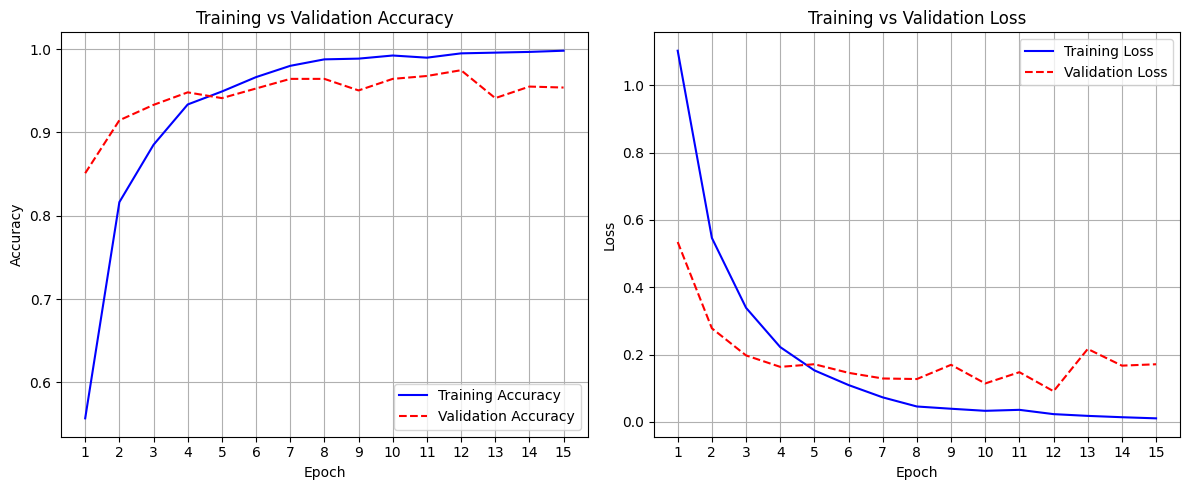

In [32]:
# Ambil data dari history
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = list(range(1, len(acc) + 1))  # <- Ini membuat angka 1, 2, 3, dst

# Plot Akurasi
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(epochs, acc, 'b-', label='Training Accuracy')
plt.plot(epochs, val_acc, 'r--', label='Validation Accuracy')
plt.title('Training vs Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.xticks(epochs)  # <-- Menampilkan angka bulat di sumbu X
plt.legend()
plt.grid(True)

# Plot Loss
plt.subplot(1, 2, 2)
plt.plot(epochs, loss, 'b-', label='Training Loss')
plt.plot(epochs, val_loss, 'r--', label='Validation Loss')
plt.title('Training vs Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.xticks(epochs)  # <-- Menampilkan angka bulat di sumbu X
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

34/34 ━━━━━━━━━━━━━━━━━━━━ 11s 252ms/step
=== Classification Report ===
                   precision    recall  f1-score   support

   Nail_psoriasis       0.99      0.99      0.99       225
          SJS-TEN       0.98      0.90      0.94       239
         Vitiligo       0.88      0.95      0.91       201
             acne       0.97      0.97      0.97       211
hyperpigmentation       0.95      0.96      0.95       209

         accuracy                           0.95      1085
        macro avg       0.95      0.95      0.95      1085
     weighted avg       0.95      0.95      0.95      1085



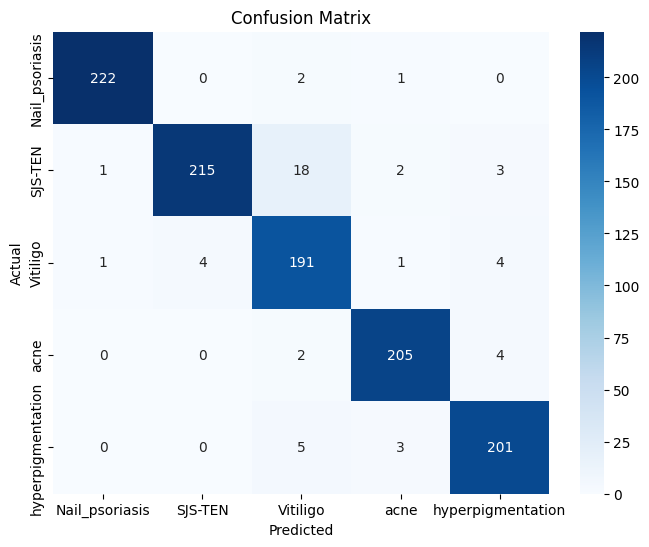

In [33]:
# Mendapatkan prediksi
y_pred_probs = model.predict(test_generator)
y_pred = np.argmax(y_pred_probs, axis=1)

# Mendapatkan label asli
y_true = test_generator.classes

# Nama kelas
class_labels = list(test_generator.class_indices.keys())

# Classification report
print("=== Classification Report ===")
print(classification_report(y_true, y_pred, target_names=class_labels))

# Confusion matrix
cm = confusion_matrix(y_true, y_pred)

# Visualisasi confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=class_labels, yticklabels=class_labels)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

# 7.Menyimpan Model ke dalam format SavedModel, TF-Lite dan TFJS

## 7.1.Format SavedModel
- Format standar untuk deployment di server atau cloud.

In [34]:
print(train_generator.class_indices)

{'Nail_psoriasis': 0, 'SJS-TEN': 1, 'Vitiligo': 2, 'acne': 3, 'hyperpigmentation': 4}


In [35]:
model.save("./my_model.keras")

## 7.2.Format TF-Lite
- Format yang optimal pada perangkat mobile dan embedded.

## 7.3.Format TFJS
- Format yang dapat dijalankan di browser dan aplikasi berbasis bahasa pemrograman JavaScript.

# 8.Testing-Inference Model

# 9.Kesimpulan